## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
featofvar = 'Type and Serum'

remote_folder = '10_04_18_COOH_PEG_serum' #Folder in AWS S3 containing files to be analyzed
bucket = 'rhodese.data'
vids = 10
types = ['COOH', 'COOH_serum', 'PEG', 'PEG_serum']

counter2 = 0
counter = 0
for typ in types:
    for num in range(1, vids+1):
            try:
                filename = 'features_{}_XY{}.csv'.format(typ, '%02d' % num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                print('{} size: {}'.format(filename, fstats.shape))
                fstats['Type and Serum'] = pd.Series(fstats.shape[0]*[typ], index=fstats.index)
                if 'serum' in typ:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['serum'], index=fstats.index)
                else:
                    fstats['Serum'] = pd.Series(fstats.shape[0]*['no serum'], index=fstats.index)
                if 'COOH' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))
    counter2 = counter2 + 1

features_COOH_XY01.csv
features_COOH_XY01.csv size: (14913, 67)
features_COOH_XY02.csv
features_COOH_XY02.csv size: (14225, 67)
features_COOH_XY03.csv
features_COOH_XY03.csv size: (14767, 67)
features_COOH_XY04.csv
features_COOH_XY04.csv size: (14936, 67)
features_COOH_XY05.csv
features_COOH_XY05.csv size: (15344, 67)
features_COOH_XY06.csv
features_COOH_XY06.csv size: (63173, 67)
features_COOH_XY07.csv
features_COOH_XY07.csv size: (42620, 67)
features_COOH_XY08.csv
features_COOH_XY08.csv size: (43427, 67)
features_COOH_XY09.csv
features_COOH_XY09.csv size: (19220, 67)
features_COOH_XY10.csv
features_COOH_XY10.csv size: (27610, 67)
features_COOH_serum_XY01.csv
features_COOH_serum_XY01.csv size: (42821, 67)
features_COOH_serum_XY02.csv
features_COOH_serum_XY02.csv size: (42778, 67)
features_COOH_serum_XY03.csv
features_COOH_serum_XY03.csv size: (42996, 67)
features_COOH_serum_XY04.csv
features_COOH_serum_XY04.csv size: (43391, 67)
features_COOH_serum_XY05.csv
features_COOH_serum_XY05.cs

In [7]:
nonnum = ['Type and Serum', 'Type', 'Serum', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [9]:
ncomp = 13
pcadataset = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.1690233471461031
1 component: 0.29080556199913105
2 component: 0.40581253217037505
3 component: 0.49458419792874936
4 component: 0.5488604855370759
5 component: 0.5930988484590081
6 component: 0.6350075583516837
7 component: 0.6755002803832567
8 component: 0.7116432917505943
9 component: 0.7392260296659202
10 component: 0.7662018045056503
11 component: 0.7904747381375375
12 component: 0.8121522325621199


In [10]:
pca_train = pcadataset

In [11]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

In [12]:
pca_train.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean fractal_dim,asymmetry3,Mean boundedness,Mean asymmetry1,Mean frames,frames,alpha,trappedness,Mean alpha,Deff1,Std MSD_ratio,Std efficiency,Std alpha
1,Mean Deff1,elongation,Mean trappedness,Mean asymmetry2,Std asymmetry3,D_fit,Std alpha,boundedness,Std MSD_ratio,kurtosis,Mean MSD_ratio,Mean efficiency,Mean alpha
2,Mean efficiency,asymmetry2,Std fractal_dim,Std asymmetry1,Std asymmetry2,trappedness,Mean alpha,Std frames,Mean MSD_ratio,D_fit,Std trappedness,Std straightness,Std boundedness
3,Std Deff1,AR,Mean kurtosis,Std asymmetry2,Std asymmetry1,boundedness,Mean kurtosis,frames,Std alpha,alpha,Std boundedness,Std alpha,Std trappedness
4,Mean straightness,asymmetry1,Std straightness,Mean elongation,Mean trappedness,straightness,Std kurtosis,Mean frames,Mean D_fit,Std MSD_ratio,Std frames,Std frames,Deff2


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [13]:
kmostat = pca.kmo(pca_train.scaled)

0.864342214154


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [14]:
import numpy as np
featofvar = 'Type and Serum'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='COOH'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='COOH_serum'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='PEG'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='PEG_serum'].values[:, -ncomp:], axis=0)

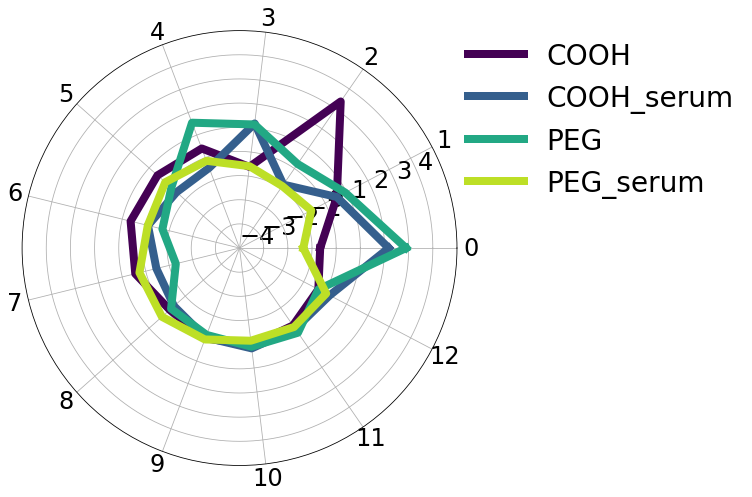

In [15]:
labels = ['COOH', 'COOH_serum', 'PEG', 'PEG_serum']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9), dpi=1200, labelsize=24,
             filename='pics/Fig3/corona_pcaavg.png')

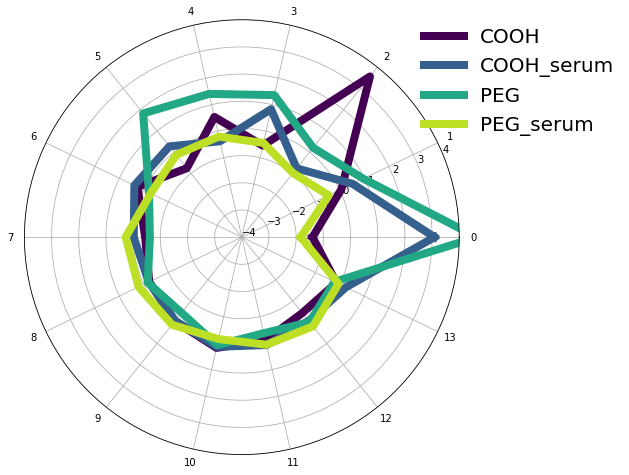

In [8]:
labels = ['COOH', 'COOH_serum', 'PEG', 'PEG_serum']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

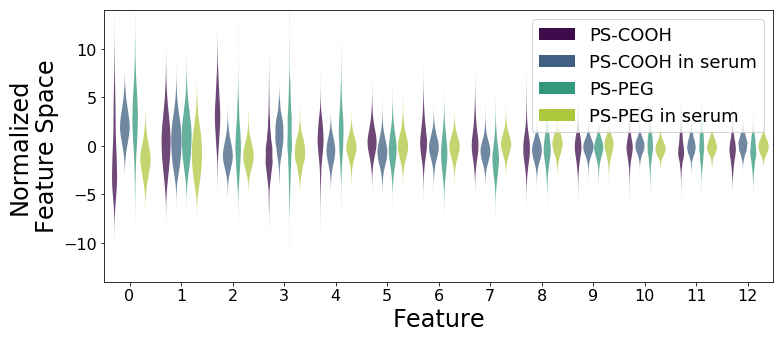

In [19]:
labels2 = ['PS-COOH', 'PS-COOH in serum', 'PS-PEG', 'PS-PEG in serum']
feats = feature_violin(pca_train.final, label=featofvar, lvals=types, labels=labels2, fsubset=ncomp, yrange=[-14, 14],
                       legendfontsize=21, labelsize=24, fname='./pics/Fig3/corona_pcadist.png')

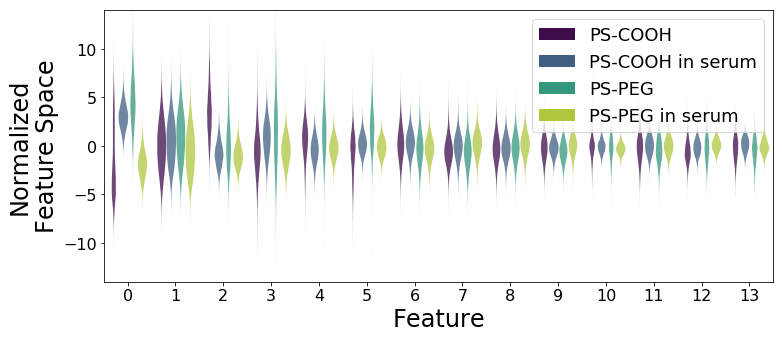

In [27]:
labels2 = ['PS-COOH', 'PS-COOH in serum', 'PS-PEG', 'PS-PEG in serum']
feats = feature_violin(pcadataset.final, label='Type and Serum', lvals=labels, labels=labels2, fsubset=14, yrange=[-14, 14],
                       legendfontsize=21, labelsize=24, fname='./pics/corona_pcadist.png')

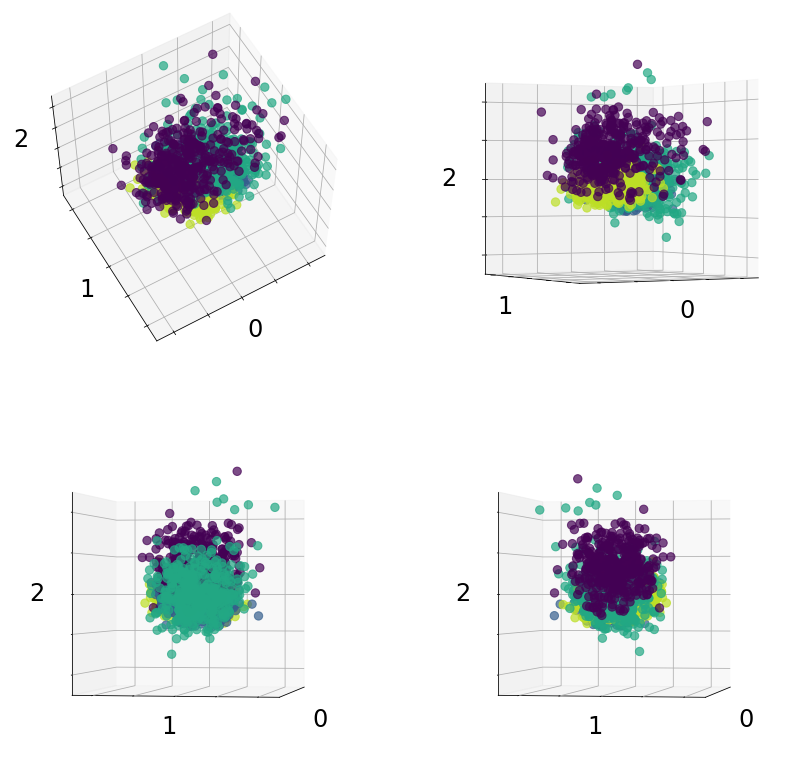

In [20]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=types, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              filename='./pics/Fig3/corona_3feats.png')

## Neural Network

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [23]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.13723445
Validation score: 0.962020
Iteration 2, loss = 0.09888533
Validation score: 0.968507
Iteration 3, loss = 0.08326189
Validation score: 0.976760
Iteration 4, loss = 0.06998112
Validation score: 0.979949
Iteration 5, loss = 0.05892040
Validation score: 0.984835
Iteration 6, loss = 0.04961282
Validation score: 0.984671
Iteration 7, loss = 0.04238085
Validation score: 0.991022
Iteration 8, loss = 0.03669939
Validation score: 0.990898
Iteration 9, loss = 0.03209468
Validation score: 0.993020
Iteration 10, loss = 0.02848159
Validation score: 0.993732
Iteration 11, loss = 0.02547389
Validation score: 0.995798
Iteration 12, loss = 0.02325785
Validation score: 0.995360
Iteration 13, loss = 0.02141553
Validation score: 0.997577
Iteration 14, loss = 0.02008137
Validation score: 0.997632
Iteration 15, loss = 0.01893547
Validation score: 0.997988
Iteration 16, loss = 0.01812004
Validation score: 0.998645
Iteration 17, loss = 0.01729195
Validation score: 0.998604
Iterat

In [1]:
fstats_tot.columns()

NameError: name 'fstats_tot' is not defined